In [1]:
from triqs_tprf.tight_binding import TBLattice
import numpy as np
import matplotlib.pyplot as plt
from triqs_tprf.lattice_utils import k_space_path

Starting serial run at: 2024-06-12 11:50:57.561285


In [2]:
s1 = np.matrix([[0,1],[1,0]])
s2 = np.matrix([[0,-1j],[1j,0]])
s3 = np.matrix([[1,0],[0,-1]])
sup = np.matrix([[1,0],[0,0]])
sdo = np.matrix([[0,0],[0,1]])
s4 = np.matrix([[1,0],[0,1]])

paulis = [s1, s2, s3, s4]

In [3]:
def model(t1, t3, spin, B):
    
    lattice = TBLattice(
    units = [(0.5, np.sqrt(3)/2, 0.0), [-0.5, np.sqrt(3)/2, 0.0]],##### Primitive vectors of a honeycomb lattice
    orbital_positions = [(0.0, 0.0, 0), (0.0, 0.0, 0), (0.0, 1/np.sqrt(3), 0), (0.0, 1/np.sqrt(3), 0)],##### 2 sublattice x 2 spins
    orbital_names = ['1up', '1do', '2up', '2do'],
    hoppings = {
        # Intra-unit cell hopping
        ( 0, 0): (np.kron(np.matrix([[0, -t1], [-t1, 0]]), paulis[spin]) - 
            np.kron(np.matrix([[1, 0], [0, 1]]), (B[0] * paulis[0] + B[1] * paulis[1] + B[2] * paulis[2])/2)),
        # Inter-unit cell hopping
        (-1, 0): np.kron(np.matrix([[0, -t1], [  0, 0]]), paulis[spin]),
        ( 0,-1): np.kron(np.matrix([[0, -t1], [  0, 0]]), paulis[spin]),
        ( 1, 0): np.kron(np.matrix([[0,   0], [-t1, 0]]), paulis[spin]),
        ( 0, 1): np.kron(np.matrix([[0,   0], [-t1, 0]]), paulis[spin]),
        (-1,-1): np.kron(np.matrix([[0, -t3], [  0, 0]]), paulis[spin]),
        ( 1,-1): np.kron(np.matrix([[0, -t3], [-t3, 0]]), paulis[spin]),
        (-1, 1): np.kron(np.matrix([[0, -t3], [-t3, 0]]), paulis[spin]),
        ( 1, 1): np.kron(np.matrix([[0,   0], [-t3, 0]]), paulis[spin]),
        },
    )
    
    return lattice

In [4]:
def bands(lattice, N):
    
    kmesh = lattice.get_kmesh(n_k=(N, N, 1))
    e_k = lattice.fourier(kmesh)
    
    band = [np.linalg.eigvalsh(e_k(kmesh[i].value)) for i in range(N**2)]
    
    return band

In [5]:
t1 = 1.0
t3 = 0.0
spin = 3
B = [0.0, 0.0, 0.0]

honeycomb = model(t1, t3, spin, B)
N = 64
kmesh = honeycomb.get_kmesh(n_k=(N, N, 1))
e_k = honeycomb.fourier(kmesh)

In [18]:
ks = np.array([k.value for k in kmesh])
ks.shape

(4096, 3)

In [11]:
G = [0.0, 0.0, 0.0]
K1 = [2/3, 1/3, 0.0]
M = [0.5, 0.5, 0.0]

paths = [(G, K1), (K1, M), (M, G)]

k_vecs, k_plot, k_ticks = k_space_path(paths, bz=honeycomb.bz)

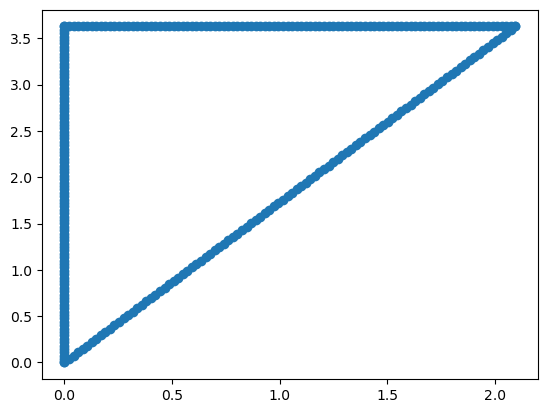

In [6]:
##### Plotting a path in k-space
plt.scatter(k_vecs[:,0], k_vecs[:,1])
plt.show()

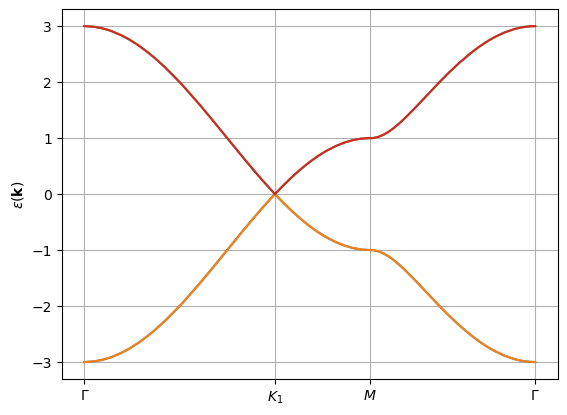

In [7]:
def energies(k, e_k):
    return np.linalg.eigvalsh(e_k(k))
##### Band structure
plt.plot(k_plot, [energies(k, e_k) for k in k_vecs])
plt.xticks(k_ticks, [r'$\Gamma$',r'$K_1$',r'$M$',r'$\Gamma$'])
plt.ylabel(r'$\epsilon(\mathbf{k})$')
plt.grid(True)

In [32]:
np.round(e_k(k_vecs[20]), 3)

array([[ 0.   +0.j   ,  0.   +0.j   , -2.573+1.158j,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   , -2.573+1.158j],
       [-2.573-1.158j,  0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   , -2.573-1.158j,  0.   +0.j   ,  0.   +0.j   ]])

In [33]:
k = k_vecs[20]
-(1+np.exp(1.0j*np.dot(-k[0:2], honeycomb.units[0][0:2]))+np.exp(1.0j*np.dot(-k[0:2], honeycomb.units[1][0:2])))

(-2.5746344234004352+1.1593787629248076j)

In [26]:
np.exp(1.0j*np.dot(k_vecs[50][0:2], honeycomb.units[1][0:2]))

(0.4908115960235679+0.87126573283287j)

In [9]:
from triqs_tprf.lattice import lindhard_chi00
from triqs.gf import MeshImFreq, Idx
from triqs_tprf.lattice import lattice_dyson_g0_wk

In [117]:
beta = 40.0
mu = 0.0
wmesh = MeshImFreq(beta=beta, S='Fermion', n_max=120)
g0_wk = lattice_dyson_g0_wk(mu=mu, e_k=e_k, mesh=wmesh)

In [118]:
from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk
chi00_wk = imtime_bubble_chi0_wk(g0_wk, nw=1)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 40.0
nk    = 4096
nw    = 240
norb  = 4

Approx. Memory Utilization: 0.70 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_w0r_from_grt_PH (bubble in tau & r)
--> chi_wk_from_chi_wr (r->k)


In [12]:
def Mags(a):
    return [np.kron(np.matrix([[ 1, 0], [ 0, 0]]), paulis[a]), np.kron(np.matrix([[ 0, 0], [ 0, 1]]), paulis[a])]

In [13]:
def S(i:int, N:int, direction:int) -> np.matrix:
    mat = np.zeros((2*N, 2*N), dtype=np.complex128)
    mat[2*i:2*i+2, 2*i:2*i+2] = paulis[direction]
    return mat

In [14]:
##### contract the full rank-4 susceptibility tensor to return a matrix
def chi_contraction(chi, i:int, j:int, N:int, direction:int):
    Si = S(i, N, direction)
    Sj = S(j, N, direction)
    
    chi_density = chi[0, 0, 0, 0].copy()
    chi_density.data[:] = np.einsum('wqabcd,ab,cd->wq', chi.data, Si, Sj)[:, :]
    chi_density = chi_density[Idx(0), :]
    return chi_density

In [15]:
def interpolate_chi(chi, k_vecs):
    assert( k_vecs.shape[1] == 3 )
    chi_interp = np.zeros(
        [k_vecs.shape[0]] + list(chi.target_shape), dtype=complex)

    for kidx, (kx, ky, kz) in enumerate(k_vecs):
        chi_interp[kidx] = chi((kx, ky, kz))

    return chi_interp

In [16]:
def interp_mat(chi, N:int, direction:int):

    chiMats = np.zeros([k_vecs.shape[0], N, N], dtype=complex)
    
    for i in range(N):
        for j in range(i+1):
            
            chi_contracted = chi_contraction(chi, i, j, N, direction)
            chiMats[:, i, j] += interpolate_chi(chi_contracted, k_vecs)

            if i != j:
                chiMats[:, j, i] += chiMats[:, i, j].conj() 
    
    return chiMats

In [13]:
def chi_contraction(chi, i, j, a):
    mags = Mags(a)
    chi_SzSz = chi[0, 0, 0, 0].copy()
    chi_SzSz.data[:] = np.einsum('wqabcd,ab,cd->wq', chi.data, mags[i], mags[j])[:, :]
    chi_SzSz = chi_SzSz[Idx(0), :]
    return chi_SzSz

In [14]:
def interpolate_chi(chi, k_vecs):
    assert( k_vecs.shape[1] == 3 )
    chi_interp = np.zeros(
        [k_vecs.shape[0]] + list(chi.target_shape), dtype=complex)

    for kidx, (kx, ky, kz) in enumerate(k_vecs):
        chi_interp[kidx] = chi((kx, ky, kz))

    return chi_interp

In [15]:
def interp_mat(chi, a, label=None):

    chiMats = np.zeros([k_vecs.shape[0], 2, 2], dtype=complex)
    
    for i in range(2):
        for j in range(i+1):
            
            chi_SzSz = chi_contraction(chi, i, j, a)
            chiMats[:, i, j] += interpolate_chi(chi_SzSz, k_vecs)
            
            if i != j:
                chiMats[:, j, i] += chiMats[:, i, j].conj()
    
    return chiMats

In [16]:
def plot_chi_eigs(chi, a):
    
    chiMat = interp_mat(chi, a)
    egs = np.linalg.eigvalsh(chiMat)
    plt.plot(k_plot, egs, label = "Bare susceptibility")
    plt.legend()
    plt.grid()
    plt.xticks(ticks=k_ticks, labels=[r'$\Gamma$',r'$X$',r'$M$',r'$\Gamma$'])
    plt.title(r'Spin-response $\chi(\mathbf{q}, \omega=0)$')

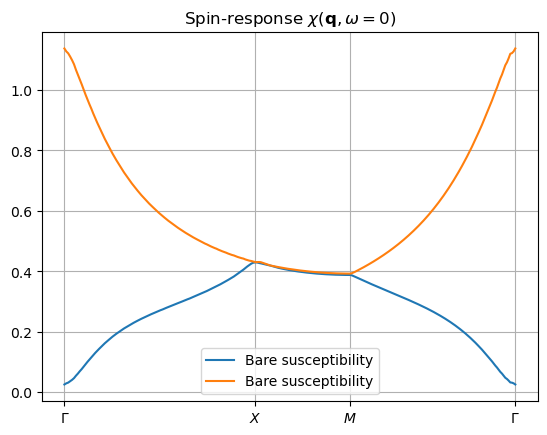

In [119]:
plot_chi_eigs(chi00_wk, 0)

In [120]:
chiXX_HS = interp_mat(chi00_wk, 0)
chiYY_HS = interp_mat(chi00_wk, 1)
chiZZ_HS = interp_mat(chi00_wk, 2)

In [124]:
fileName = f"t1={t1}_t3={t3}_beta={beta}_Bx={B[0]}_suscepHS.npz"
np.savez(fileName, chiXX=chiXX_HS, chiYY=chiYY_HS, chiZZ=chiZZ_HS, ks=k_vecs, beta = beta, mu = mu, 
        reciprocal = kmesh.bz.units, primitives=honeycomb.units, path = paths, bz = bz,
        chiXX_full = chiXX, chiYY_full = chiYY, chiZZ_full = chiZZ)

In [3]:
honeycomb.units

NameError: name 'honeycomb' is not defined

In [23]:
chiDD = np.zeros([N**2, 2, 2], dtype=complex)
for i in range(2):
        for j in range(i+1):
            chiDD[:, i, j] = chi_contraction(chi00_wk, i, j, 2, 1).data
            
            if i != j:
                chiDD[:, j, i] = np.conj(chiDD[:, i, j])

In [112]:
bz

array([[ 0.        ,  0.        ,  0.        ],
       [-0.09817477,  0.05668123,  0.        ],
       [-0.19634954,  0.11336246,  0.        ],
       ...,
       [ 0.19634954,  7.02847254,  0.        ],
       [ 0.09817477,  7.08515377,  0.        ],
       [ 0.        ,  7.141835  ,  0.        ]])

In [121]:
chiXX = np.zeros((N**2, 2, 2), dtype = np.complex128)
chiYY = np.zeros((N**2, 2, 2), dtype = np.complex128)
chiZZ = np.zeros((N**2, 2, 2), dtype = np.complex128)

In [122]:
for i in range(2):
    for j in range(2):
        chiXX[:, i, j] = chi_contraction(chi00_wk, i, j, 0).data
        chiYY[:, i, j] = chi_contraction(chi00_wk, i, j, 1).data
        chiZZ[:, i, j] = chi_contraction(chi00_wk, i, j, 2).data

In [111]:
chiXX.shape

(4096, 2, 2)

In [84]:
kmesh

TypeError: 'builtin_function_or_method' object is not subscriptable

In [24]:
chiZZ.shape

(4096, 2, 2)

In [25]:
chis = np.zeros((N**2, 6, 6), dtype = np.complex128)
chis[:, np.array([0, 3])[:, None], np.array([0, 3])] = chiXX
chis[:, np.array([1, 4])[:, None], np.array([1, 4])] = chiYY
chis[:, np.array([2, 5])[:, None], np.array([2, 5])] = chiZZ

In [26]:
chiMatXX = interp_mat(chi00_wk, 0)
chiMatYY = interp_mat(chi00_wk, 1)
chiMatZZ = interp_mat(chi00_wk, 2)

In [27]:
chiMats = np.zeros([300, 6, 6], dtype=complex)
chiMats[:, np.array([0, 3])[:, None], np.array([0, 3])] = chiMatXX
chiMats[:, np.array([1, 4])[:, None], np.array([1, 4])] = chiMatYY
chiMats[:, np.array([2, 5])[:, None], np.array([2, 5])] = chiMatZZ


In [29]:
def XXZ(l):
    return np.matrix([[1, 0, 0], [0, 1, 0], [0, 0, l]])

In [30]:
def J1Mat(J1, l, k):
    mat = XXZ(l)
    kx, ky, kz = k
    k1 =  0.5*kx + np.sqrt(3)/2 * ky
    k2 = -0.5*kx + np.sqrt(3)/2 * ky
    
    J = np.zeros((6,6), dtype=complex)
    J[0:3, 3:6] = J1 * mat * (1.0 + np.exp(1j*k1) + np.exp(1j*k2))
    J[3:6, 0:3] = J[0:3, 3:6].conj().T

    return J

In [31]:
def J3Mat(J3, l, k):
    mat = XXZ(l)
    kx, ky, kz = k
    k1 =  0.5*kx + np.sqrt(3)/2 * ky
    k2 = -0.5*kx + np.sqrt(3)/2 * ky
    
    J = np.zeros((6,6), dtype=complex)
    J[0:3, 3:6] = J3 * mat * (2 * np.cos(k1-k2) + np.exp(1j*(k1+k2)))
    J[3:6, 0:3] = J[0:3, 3:6].conj().T

    return J

In [32]:
def JMat(J1, J3, l, k):
    return J1Mat(J1, l, k) + J3Mat(J3, l, k)

In [33]:
J = 0.25*t1
J1 = -1.0 * J
J3 = +0.0 * J
l = 0.0 
Js = np.zeros((300, 6, 6), dtype=complex)
for (idx, k) in enumerate(k_vecs):
    Js[idx, :, :] = JMat(J1, J3, l, k)

In [35]:
chiMats.shape
Js.shape

(300, 6, 6)

In [34]:
def chi_Mat_RPA(chis, Js):
    
    corrections = np.matmul(chis, Js)
    corrections = np.identity(6)[np.newaxis, :, :] + corrections
    corrections = np.linalg.inv(corrections)
    
    chiMatRPA = np.matmul(corrections, chis)
    
    return chiMatRPA

In [68]:
def plot_chi_eigsRPA(chi, Js):
    
    chiMatRPA = chi_Mat_RPA(chi, Js)
    egs = np.linalg.eigvalsh(chiMatRPA)
    
    plt.plot(k_plot, egs, label = "RPA susceptibility")
    plt.legend()
    plt.grid()
    plt.xticks(ticks=k_ticks, labels=[r'$\Gamma$',r'$K_1$',r'$M$',r'$\Gamma$'])
    plt.title(r'Spin-response $\chi(\mathbf{q}, \omega=0)$')

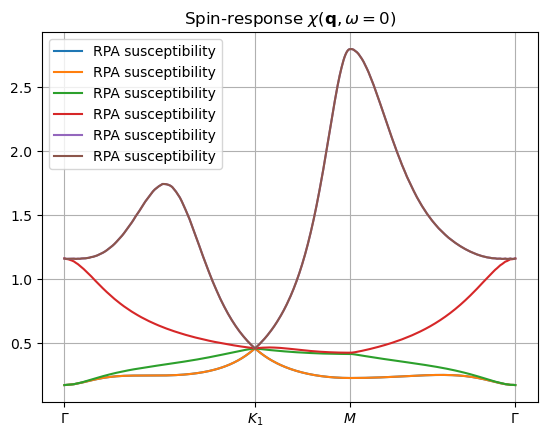

In [75]:
J = 0.5*t1
J1 = -1.0 * J
J3 = +1.0 * J
l = 0.0 
Js = np.zeros((300, 6, 6), dtype=complex)
for (idx, k) in enumerate(k_vecs):
    Js[idx, :, :] = JMat(J1, J3, l, k)


plot_chi_eigsRPA(chiMats, Js)

In [72]:
chiRPA = chi_Mat_RPA(chiMats, Js)
k_ind = 0
egs, wavefunctions = np.linalg.eigh(chiRPA[k_ind])
print(k_vecs[k_ind])
print(np.round(egs, 4))
print(np.round(wavefunctions[:, 4], 4))
print(np.round(wavefunctions[:, 5], 4))

[0. 0. 0.]
[0.1629 0.1629 0.1713 1.1601 1.7795 1.7795]
[-0.6708+0.j -0.2236+0.j  0.    -0.j -0.6708-0.j -0.2236-0.j  0.    +0.j]
[ 0.2236+0.j -0.6708+0.j  0.    -0.j  0.2236+0.j -0.6708-0.j  0.    +0.j]


In [33]:
k_vecs[100]

array([2.0943951 , 3.62759873, 0.        ])

In [32]:
kmesh.bz.units[0]*(2/3)+kmesh.bz.units[1]*(1/3)

array([2.0943951 , 3.62759873, 0.        ])

In [57]:
fileName = "t1=1.0_t3=0.2_beta=20_suscep.npz"
np.savez(fileName, chiXX=chiXX, chiYY=chiYY, chiZZ=chiZZ, ks=ks, beta = beta, mu = mu, reciprocal = kmesh.bz.units, primitives=honeycomb.units)

In [76]:
import inspect

In [93]:
import inspect
for i in inspect.getmembers(kmesh):
     
    # to remove private and protected
    # functions
    if not i[0].startswith('_'):
         
        # To remove other methods that
        # doesnot start with a underscore
        if not inspect.ismethod(i[1]): 
            print(i)

('bz', Brillouin Zone with 2 dimensions and reciprocal matrix 
[[6.28319,3.6276,0]
 [-6.28319,3.6276,0]
 [0,-0,6.28319]])
('closest_index', <built-in method closest_index of triqs.gf.meshes.MeshBrZone object at 0x70344bdd26d0>)
('copy', <built-in method copy of triqs.gf.meshes.MeshBrZone object at 0x70344bdd26d0>)
('copy_from', <built-in method copy_from of triqs.gf.meshes.MeshBrZone object at 0x70344bdd26d0>)
('dims', [64, 64, 1])
('mesh_hash', 1439622011272493326)
('to_data_index', <built-in method to_data_index of triqs.gf.meshes.MeshBrZone object at 0x70344bdd26d0>)
('to_index', <built-in method to_index of triqs.gf.meshes.MeshBrZone object at 0x70344bdd26d0>)
('to_value', <built-in method to_value of triqs.gf.meshes.MeshBrZone object at 0x70344bdd26d0>)
('units', array([[ 0.09817477,  0.05668123,  0.        ],
       [-0.09817477,  0.05668123,  0.        ],
       [ 0.        ,  0.        ,  6.28318531]]))
('values', <built-in method values of triqs.gf.meshes.MeshBrZone object at 

In [123]:
bz = np.array([kmesh[i].value for i in range(N**2)])

In [108]:
bz.shape

(4096, 3)

In [82]:
honeycomb.units

array([[ 0.5      ,  0.8660254],
       [-0.5      ,  0.8660254]])

In [32]:
paulis[2]

matrix([[ 1,  0],
        [ 0, -1]])

In [37]:
kmesh[4095].value

array([0.      , 7.141835, 0.      ])